# Purpose
The purpose of this notebook is to apply the KVP emulator to two-body scattering with a square well interaction.

# Notebook Setup

## Library import
We import all the required Python libraries

In [1]:
import pandas as pd
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload    
%autoreload 2

## Local library import
We import all the required local libraries.

In [2]:
from mesh import BuildMesh
from emulator_scattering import KVP_emulator_scattering
from square_well import SquareWell

## Parameters

In [3]:
### Square well parameters ###
V0 = 1
R = 1
E_scat = 5

### MESH INPUT PARAMETERS ###
ki = 0
cut_reg1 = R - 0.01 # Mesh cutoff of first region
cut_reg2 = R + 0.01 # Mesh cutoff of second region
kf = 3

pts_reg1 = 30 # Total points in first region
pts_reg2 = 60 # Total points in second region
pts_reg3 = 30 # Total points in third region
Ntot = pts_reg1 + pts_reg2 + pts_reg3

### EC parameters ###
nugget = 0

In [4]:
mesh_nodes = [ki, cut_reg1, cut_reg2, kf]
pts_per_region = [pts_reg1, pts_reg2, pts_reg3]
mesh = BuildMesh(mesh_nodes, pts_per_region, inf_map=False)
ps, ws = mesh.nodes, mesh.weights

## Calculate exact quantities
This calculates all the exact quantities we are trying to predict for comparison.

In [5]:
k0 = np.sqrt(2 * E_scat)
sw_exact = SquareWell(V0, R)
V_exact = sw_exact.Vr(ps)
psi_exact = sw_exact.wf_norm_scat(ps, E_scat)
tau_exact = 1.0 / sw_exact.scat_amp(k0)

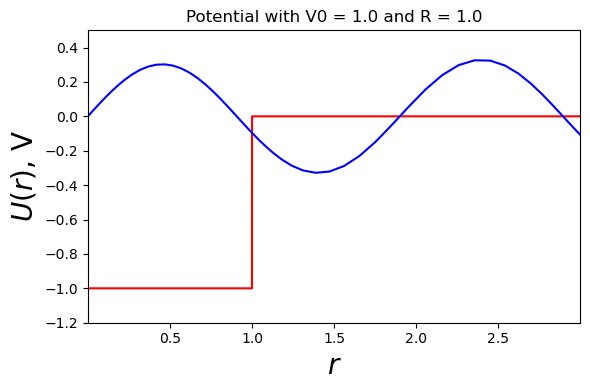

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(ps, V_exact, color='red')
ax.plot(ps, psi_exact, color='blue')
ax.set_xlim(ps[0], ps[-1])
ax.set_ylim(-1.2 * sw_exact.V0, 0.5 * sw_exact.V0)
ax.set_title(fr'Potential with V0 = {V0:.1f} and R = 1.0')
ax.set_xlabel(r'$r$', fontsize=20)
ax.set_ylabel(r'$U(r)$, V', fontsize=20)

fig.tight_layout()

## Calculate basis quantities
This calculates all the quantities that will be used for the basis.

In [7]:
V0_b = np.array([30.0, 20.0, 15.0, 10.0, 5.0])

psi_b = np.zeros((V0_b.shape[0], len(ps)))
V_b = np.zeros((V0_b.shape[0], len(ps)))
tau_b = np.zeros((1, V0_b.shape[0]))

for i, V0_i in enumerate(V0_b):
    sw_b = SquareWell(V0_i, R)
    V_b[i] = sw_b.Vr(ps)
    psi_b[i] = sw_b.wf_norm_scat(ps, E_scat)
    tau_b[0][i] = 1.0 / sw_b.scat_amp(k0)

# Implementation

In [8]:
emu = KVP_emulator_scattering(k0, ps, ws)
emu.train(psi_b, V_b, V_exact)
tau_var, c_var = emu.prediction(tau_b, nugget)

print("Tau exact:", tau_exact)
print("Tau variational:", tau_var)
print("Tau abs error:", abs(tau_exact - tau_var))

Tau exact: 0.0893622880782628
Tau variational: 0.08928609867318393
Tau abs error: 7.618940507886363e-05


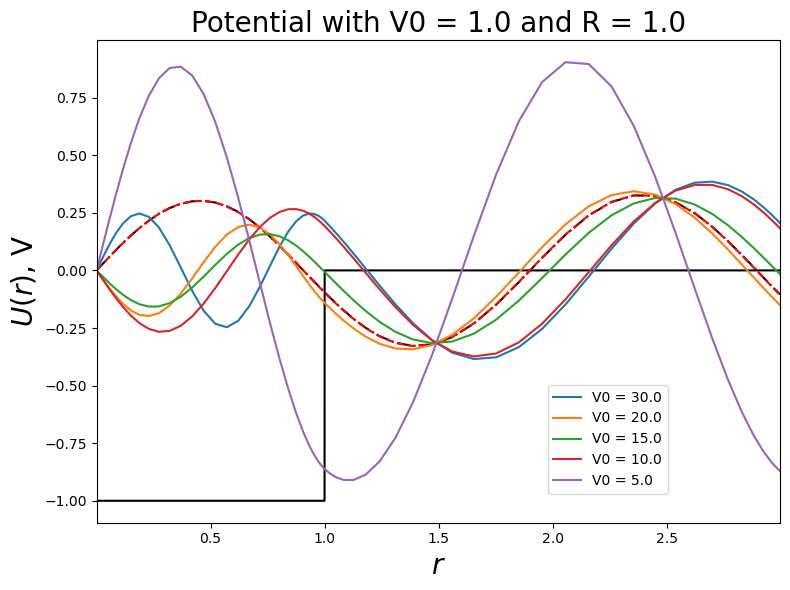

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(ps, V_exact, color='black')
ax.plot(ps, (c_var @ psi_b)[0], color='black', linestyle='dashdot')
ax.plot(ps, psi_exact, color='red', linestyle='dashed')

for V0_i, wf_i in zip(V0_b, psi_b):
    ax.plot(ps, wf_i, label=f'V0 = {V0_i:1.1f}')
    
ax.set_xlim(ps[0], ps[-1])
ax.set_title(fr'Potential with V0 = {V0:.1f} and R = 1.0', fontsize=20)
ax.set_xlabel(r'$r$', fontsize=20)
ax.set_ylabel(r'$U(r)$, V', fontsize=20)
plt.legend(bbox_to_anchor=(0.65, 0.3), loc='upper left')

fig.tight_layout()